In [60]:
from tensorflow.keras.datasets import mnist

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt

### 01 Get the data

In [71]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28))
x_test = np.reshape(x_test, (len(x_test), 28, 28))


In [25]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


#### 01a Pad the train data with -1 for left hand side

In [27]:
x_train_left=[]
for i in range(x_train.shape[0]):
    x_train_left.append(np.pad(x_train[i],(1,1),'constant',constant_values=(-1)))
x_train_left=np.array(x_train_left)
x_train_left = x_train_left.astype('float32') / 255.
x_train_left = np.reshape(x_train_left, (len(x_train_left), 30, 30, 1))
print(x_train_left.shape)    

(60000, 30, 30, 1)


#### 01b Pad the train data with y_values for right hand side

In [28]:
x_train_right=[]
for i in range(x_train.shape[0]):
    x_train_right.append(np.pad(x_train[i],(1,1),'constant',constant_values=(y_train[i])))
    
x_train_right=np.array(x_train_right)
x_train_right = x_train_right.astype('float32') / 255.
x_train_right = np.reshape(x_train_right, (len(x_train_right), 30, 30, 1))
print(x_train_right.shape)    

(60000, 30, 30, 1)


#### 01c Pad the test data with -1 for left hand side

In [29]:
x_test_left=[]
for i in range(x_test.shape[0]):
    x_test_left.append(np.pad(x_test[i],(1,1),'constant',constant_values=(-1)))
x_test_left=np.array(x_test_left)
x_test_left = x_test_left.astype('float32') / 255.
x_test_left = np.reshape(x_test_left, (len(x_test_left), 30, 30, 1))
print(x_test_left.shape)    

(10000, 30, 30, 1)


#### 01d Pad the test data with y values for right hand side

In [30]:
x_test_right=[]
for i in range(x_test.shape[0]):
    x_test_right.append(np.pad(x_test[i],(1,1),'constant',constant_values=(y_test[i])))
x_test_right=np.array(x_test_right)
x_test_right = x_test_right.astype('float32') / 255.
x_test_right = np.reshape(x_test_right, (len(x_test_right), 30, 30, 1))
print(x_test_right.shape)    

(10000, 30, 30, 1)


### 02 Create and train the model

In [36]:
input_img = keras.Input(shape=(30, 30, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = layers.MaxPooling2D((3, 3), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling2D((5, 5), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = layers.UpSampling2D((5, 5))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((3, 3))(x)
x = layers.Conv2D(15, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

optimizer = keras.optimizers.Adam(lr=0.01)
autoencoder.compile(loss='binary_crossentropy', optimizer=optimizer)


# autoencoder.compile(optimizer='sgd', loss='mse', lr=0.01)


In [37]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 30, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 15, 15, 8)         0     

In [38]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train_left, x_train_right,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_left, x_test_right))


Using TensorFlow backend.


Epoch 1/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1928 - val_loss: 0.1103
Epoch 2/50
469/469 [==============================] - 9s 19ms/step - loss: 0.1069 - val_loss: 0.1037
Epoch 3/50
469/469 [==============================] - 9s 19ms/step - loss: 0.1010 - val_loss: 0.0972
Epoch 4/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0984 - val_loss: 0.0948
Epoch 5/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0965 - val_loss: 0.0956
Epoch 6/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0953 - val_loss: 0.0948
Epoch 7/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0953 - val_loss: 0.0941
Epoch 8/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0938 - val_loss: 0.0923
Epoch 9/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0931 - val_loss: 0.0923
Epoch 10/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0926 - val_l

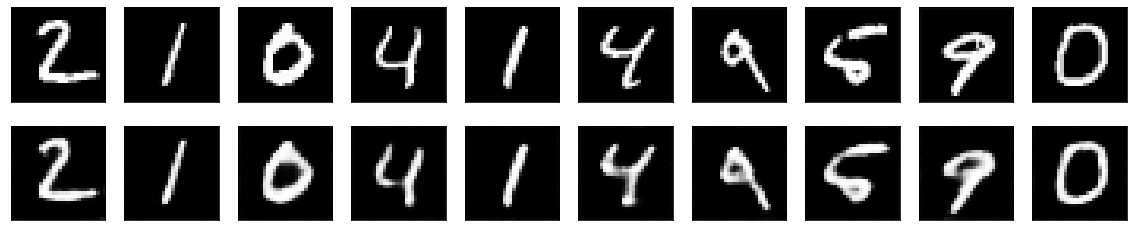

In [39]:
decoded_imgs = autoencoder.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i].reshape(30, 30))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(30, 30))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [41]:
autoencoder.save("models/mnist/autoencoder_with_label.h")

INFO:tensorflow:Assets written to: models/mnist/autoencoder_with_label.h/assets


In [42]:
new_autoenc=load_model("models/mnist/autoencoder_with_label.h/")

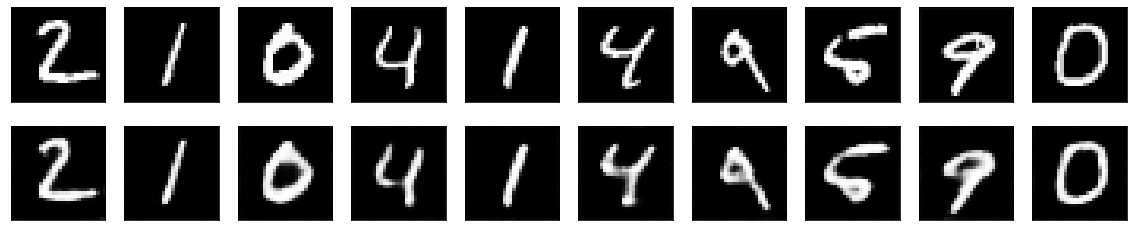

In [43]:
decoded_imgs = new_autoenc.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i].reshape(30, 30))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(30, 30))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### 03 Extract features and test with LogReg

In [44]:
encoder = Model(inputs=input_img, outputs=encoded)
encoder.save('models/mnist/encoder_with_label.h5')

In [57]:
def flatten_encoded_images_for_logreg(X_array):
    print(X_array.shape)
    X_array_flattened=[]
    for i in range(X_array.shape[0]):
        X_array_flattened.append(X_array[i].flatten())
    X_array_flattened=np.array(X_array_flattened)
    print("Shape is ",X_array_flattened.shape)
    return X_array_flattened

In [59]:
# load the model from file
encoder = load_model('models/mnist/encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
x_train_encode_flat=flatten_encoded_images_for_logreg(x_train_encode)

# x_train_encode=x_train_encode.flatten()
print("Shape of encoded flat",x_train_encode_flat.shape)
# encode the test data
x_test_encode = encoder.predict(x_test_left)
x_test_encode_flat=flatten_encoded_images_for_logreg(x_test_encode)
print("Shape of encoded flat",x_test_encode.shape)



(60000, 5, 5, 8)
Shape is  (60000, 200)
Shape of encoded flat (60000, 200)
(10000, 5, 5, 8)
Shape is  (10000, 200)
Shape of encoded flat (10000, 5, 5, 8)
0.9466


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [61]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(x_train_encode_flat, y_train)
# make predictions on the test set
yhat = model.predict(x_test_encode_flat)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.9466


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 04 Extract features and Test with a CNN

In [81]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

#### 04a Convert y values to categorical

In [72]:
#one-hot encode target column
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape,y_test_one_hot.shape)

(60000, 10) (10000, 10)


#### 04b Extract features using encoder

In [63]:
# load the model from file
encoder = load_model('models/mnist/encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
print("Shape of training encoded images",x_train_encode.shape)

# encode the test data
x_test_encode = encoder.predict(x_test_left)
print("Shape of testing encoded images",x_test_encode.shape)


Shape of training encoded images (60000, 5, 5, 8)
Shape of testing encoded images (10000, 5, 5, 8)


In [64]:
print(x_train_encode[0].shape,x_test_encode[1].shape)

(5, 5, 8) (5, 5, 8)


### 04c create a CNN that takes encoded image as input

In [84]:
# define a CNN to make the predictions
#create model
model = Sequential()#add model layers
model.add(Conv2D(64, kernel_size=2, activation='relu', input_shape=x_train_encode[0].shape))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
num_epochs=50
history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)

loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
print("Accuracy is ",acc)



313/313 [==============================] - 0s 710us/step - loss: 0.0904 - accuracy: 0.9819
Accuracy is  0.9818999767303467


In [85]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

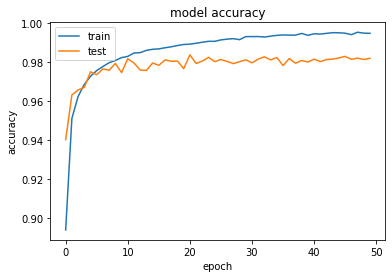